In [1]:
import pandas as pd
pd.set_option("display.max_rows", 18)

from tqdm import tqdm
tqdm.pandas()

from shapely import wkt
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
from functions.sparql_requests import sparql_select
from functions.general_functions import pickleload, pickledump

from functions.analyzing import get_gt_column, get_success_level, get_columns_for_results, get_answers_from_non_rag_response,\
                                calculate_metrics_non_rag, calculate_metrics

In [2]:
full_data = pd.concat([pickleload(f"data/with_all_answers_{i}.pkl") for i in range(5)])

# Excluding Bounding Boxes that are too big
One question asks about cities in bounding boxes. Since the database uses the EPSG:3035 crs but bounding boxes would naturally be reffering to cartesian coordinates, there are differences between the used bounding boxes for ground truth and the correct ones. If the correct bounding box is less than 90 % or more than 110 % of the size of the used bounding box the question is excluded.

<Axes: >

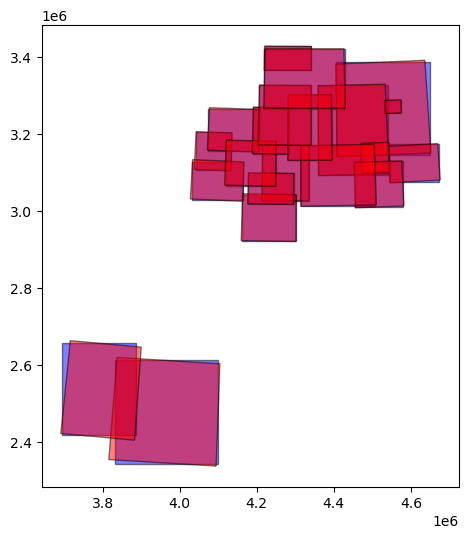

In [4]:
q = """
PREFIX geo: <http://www.opengis.net/ont/geosparql#> 
PREFIX geof: <http://www.opengis.net/def/function/geosparql/> 
PREFIX gn: <https://www.geonames.org/ontology#> 
PREFIX skos: <http://www.w3.org/2004/02/skos/core#> 
PREFIX nutsdef: <http://data.europa.eu/nuts/>

SELECT ?city ?notation ?codeWKT
WHERE {
  ?code a skos:Concept ;
    	skos:notation ?notation ;
        nutsdef:level "2" ;
        geo:hasGeometry ?codeGeom .
    BIND(str(?codeGeom) as ?temp)
    FILTER(CONTAINS(?temp, "ETRS89"))
  ?codeGeom geo:asWKT ?codeWKT .
}"""

# get only the cities that were at least 10 times the example

codes = sparql_select(q)
codes["codeWKT"] = codes["codeWKT"].apply(wkt.loads)
gdf = gpd.GeoDataFrame(codes, geometry="codeWKT", crs=3035)
gdf4326 = gdf.to_crs(4326)

gdf["bounds"] = gdf.codeWKT.apply(lambda x: box(*x.bounds))
gdf = gdf.set_geometry("bounds")
gdf4326["bounds"] = gdf4326.codeWKT.apply(lambda x: box(*x.bounds))
gdf4326 = gdf4326.set_geometry("bounds")
gdf43263035 = gdf4326.to_crs(3035)

idxs = []
exclude_codes =  []
for i in range(len(gdf4326)):
    polygood = gdf43263035.loc[i].bounds
    polybad = gdf.loc[i].bounds

    ratio = polygood.area / polybad.area
    if ratio < 0.90 or ratio > 1.10:
        # print(gdf43263035.loc[i].notation)
        idxs.append(i)
        exclude_codes.append(gdf.loc[i].notation)
        
fig, ax = plt.subplots(figsize=(8, 6))

# Plot geometries from both GeoDataFrames
gdf.loc[:20].plot(ax=ax, color='blue', edgecolor='black', alpha=0.5, label="GeoDF 1")
gdf43263035.loc[:20].plot(ax=ax, color='red', edgecolor='black', alpha=0.5, label="GeoDF 2")

In [5]:
def check_codes(row):
    inputs = row.inputs
    if "CODE" in inputs:
        if type(inputs["CODE"]) == str:
            codes = [inputs["CODE"]]
        else:
            codes = inputs["CODE"]

        for code in codes:
            if code in exclude_codes:
                return True
    return False

mask = full_data.apply(check_codes, axis=1)
full_data = full_data[~mask]

# Calculating quality metrics

### Define the correct format of the answer
For each type of question, a certain type of answer is expected. For example a True/False answer for "Is region X west of region Y?". For others it would be a list of cities. E.g. what are all the cities within 4 km of region X. So for each question the type and the column name in the ground truth answers are defined.

In [8]:
# format {question: (type, column-name)
answers_types = ["code_iri", "boolean", "direction", "cities", "single_city"] # city is both for now
alt_types = {"code": "code_iri",
             "pref_label": "code_iri",
             "city_iri": "city"}

answer_type = {   
# simple topology
    "What are all the NUTS regions that contain the city CITY?": ("code_iri", "code"),
    "What NUTS regions are within the region CODE?": ("code_iri", "otherRegion"),
    
# Neighborhood 
    "Is the NUTS region CODE bordering the region CODE?": ("boolean", "bordering"),
    "What regions of the same level are neighbors of the NUTS region CODE?": ("code_iri", "neighbor"),
    "What are the second order neighbors of the same NUTS level for the NUTS region CODE?": ("code_iri", "secondOrderNeighbor"),

# Directions (all combinations of city and region) BOOL
    "Is NUTS region CODE DIRECTION of NUTS region CODE?": ("boolean", "is{}Of"),
    "Is the NUTS region CODE DIRECTION of the city of CITY?": ("boolean", "is{}Of"),

# Directions question
    "To which direction is CITY from CITY?": ("direction", "direction"),
    "CITY is to which direction of NUTS region CODE?": ("direction", "direction"),

# Proximity
    "Is CITY within SMALLDISTANCE km of the NUTS region CODE?": ("boolean", "isWithin"),
    "What are all cities within SMALLDISTANCE km of CITY?": ("cities", "cityName"),
    "What are all cities CCONDITION and are less than BIGDISTANCE km from the NUTS region CODE?": ("cities", "cityName"),
    "What is the largest city that can be found within the bounding box of the NUTS region CODE?": ("single_city", "cityName"),
    "What is the largest city within BIGDISTANCE km of the NUTS region CODE?": ("single_city", "cityName"),

# Combinations
    "What are cities within SMALLDISTANCE kilometers to the DIRECTION of the NUTS region CODE?": ("cities", "cityName"),
    "Which cities can be found not further than SMALLDISTANCE km to the DIRECTION of CITY?": ("cities", "cityName"),
    "What NUTS regions share a border with the region CODE in the DIRECTION on the same nuts level?": ("code_iri", "region_code"),
    "What is the closest city to the DIRECTION of the NUTS region CODE?": ("single_city", "cityName")
}

full_data["answer_type"] = full_data.apply(lambda x: answer_type[x.question_raw][0], axis=1)
full_data["gt_results_column"] = full_data.progress_apply(get_gt_column, answer_type=answer_type, axis=1)

100%|█████████████████████████████████████████████████████████████████████████| 28668/28668 [00:00<00:00, 42118.02it/s]


# Calculating success level
For each question, the retrieved answer from the LLM-generated SPARQL query is checked. If the query was not valid, or failed while executing the success_type will be different. If The query succeeded and produced a column with the inteded datatype it will be considered for the accuracy assessment. .

In [10]:
assessed = full_data.progress_apply(get_success_level, answer_type=answer_type, axis=1)

100%|██████████████████████████████████████████████████████████████████████████| 28668/28668 [00:14<00:00, 1995.70it/s]


In [11]:
full_data[["success_level", "relevant_column"]] = assessed.progress_apply(lambda x: [x, "NOT_IMPORTANT"] if type(x) == str else [x[0], x[1]]).tolist()

100%|█████████████████████████████████████████████████████████████████████████| 28668/28668 [00:00<00:00, 34742.62it/s]


In [12]:
full_data["column_to_analyze"] = full_data.apply(lambda x: get_columns_for_results(x["results_from_graph_db"], x["relevant_column"], x["success_level"], idx=x.name), axis=1)

### Drop unwanted data
In some special cases (n = 8) the ground truth query did not produce a correct result, they are deleted here. Further, the `only_success` dataframe contains only the rows where the query could be executed.


In [14]:
# full_data = full_data.sample(120)

In [15]:
# DROP the 8ish columns that did not produce a valid gt answer
full_data = full_data[full_data["gt_results_column"] != "TO_DROP"]

# both empty are not considered here
only_success = full_data[full_data.column_to_analyze.notna()]

In [16]:
only_success.groupby("model_str").size()

model_str
ft:gpt-4o-mini-2024-07-18:university-of-vienna:test2-train:A2z3fBsQ    6004
gpt-4o                                                                 7503
gpt-4o-mini                                                            2576
dtype: int64

# Assessing non-RAG LLM answers

In [18]:
full_data[["detected_answers_non_rag", "hallucination_rate_nuts"]] = full_data.progress_apply(get_answers_from_non_rag_response, axis=1).tolist()

100%|████████████████████████████████████████████████████████████████████████████| 28668/28668 [06:19<00:00, 75.54it/s]


In [19]:
full_data[["precision_non_rag", "recall_non_rag", "f1_non_rag"]] = full_data.progress_apply(calculate_metrics_non_rag, axis=1).tolist()

100%|██████████████████████████████████████████████████████████████████████████| 28668/28668 [00:03<00:00, 9324.86it/s]


# Check results

In [21]:
table = pd.pivot_table(full_data, values=["precision_non_rag", "recall_non_rag", "f1_non_rag", "hallucination_rate_nuts"], index=["model_str", "temperature"], aggfunc="mean")

pd.set_option("display.max_rows", None)
table = table.style.highlight_max(subset=["precision_non_rag", "recall_non_rag", "f1_non_rag", "hallucination_rate_nuts"], color = 'pink', axis = 0)
table

In [22]:
pd.set_option("display.max_rows", 10)

In [23]:
only_success.loc[:,["precision", "recall", "f1"]] = only_success.apply(calculate_metrics, axis=1).tolist()

In [24]:
full_data.loc[:,["precision", "recall", "f1"]] = [0, 0, 0]
full_data.loc[only_success.index,["precision", "recall", "f1"]] = only_success[["precision", "recall", "f1"]]

C:\Users\arbeit\AppData\Local\Temp\ipykernel_13572\2369802392.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.         1.         1.         ... 1.         1.         0.66666667]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  full_data.loc[only_success.index,["precision", "recall", "f1"]] = only_success[["precision", "recall", "f1"]]
C:\Users\arbeit\AppData\Local\Temp\ipykernel_13572\2369802392.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.16666667 1.         1.         ... 1.         1.         1.        ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  full_data.loc[only_success.index,["precision", "recall", "f1"]] = only_success[["precision", "recall", "f1"]]
C:\Users\arbeit\AppData\Local\Temp\ipykernel_13572\2369802392.

In [25]:
full_data.groupby("model_str").apply(lambda x: x.isna().sum())["column_to_analyze"]

C:\Users\arbeit\AppData\Local\Temp\ipykernel_13572\638409545.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  full_data.groupby("model_str").apply(lambda x: x.isna().sum())["column_to_analyze"]


model_str
ft:gpt-4o-mini-2024-07-18:university-of-vienna:test2-train:A2z3fBsQ    3553
gpt-4o                                                                 2055
gpt-4o-mini                                                            6977
Name: column_to_analyze, dtype: int64

# Setting both empty to f1, precision, recall = 1

In [27]:
both_empty_index = full_data[full_data.success_level == "both_empty"].index

full_data.loc[both_empty_index, ["f1", "precision", "recall"]] = 1

# Create overview table

In [29]:
table = pd.pivot_table(full_data, values=["precision", "recall", "f1"], index=["model_str", "temperature", "ontology", "template"], aggfunc="mean")
group_sizes = full_data.groupby(["model_str", "temperature", "ontology", "template"]).size()
sucess = full_data.groupby(["model_str", "temperature", "ontology", "template"]).apply(lambda x: x.notna().sum())["column_to_analyze"]

table["group_size"] = group_sizes
table["sucess"] = sucess
table["sucess_rate"] = table["sucess"] / table["group_size"]
# table["sucess_rate"] = sucess_rate

pd.set_option("display.max_rows", None)
table = table.style.highlight_max(subset=["precision", "recall", "f1"], color = 'pink', axis = 0)
table

C:\Users\arbeit\AppData\Local\Temp\ipykernel_13572\521626898.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sucess = full_data.groupby(["model_str", "temperature", "ontology", "template"]).apply(lambda x: x.notna().sum())["column_to_analyze"]


In [34]:
n = 10
split_size = len(full_data) // n

df_parts = [full_data.iloc[i * split_size: (i + 1) * split_size] for i in range(n - 1)]
df_parts.append(full_data.iloc[(n - 1) * split_size:]) 

for i, dfc in enumerate(df_parts):
    pickledump(dfc, f"../data/with_assessment_{i}.pkl")